In [1]:
# Import các thư viện cần thiết
import numpy as np
import cv2
import pandas as pd
import os
import pickle
from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
# Connect Google Drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/test_opencv/'
# Hiển thị tất cả thư mục hoặc file
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['image_20.jpg',
 'image_40.jpg',
 'models',
 'anh.png',
 'testanh.png',
 '27.ipynb',
 'FaceImage',
 '31c_data_preprocessing.ipynb']

In [3]:
# Face detection model
faceDetectionModel = path + "/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"

# Mô tả kiến trúc
faceDetectionProto = path + "/models/deploy.prototxt.txt"

# Mô hình mô tả khuôn mặt
faceDescriptor = path + "/models/openface.nn4.small2.v1.t7"

# Sử dụng OpenCV DNN đọc mô hìn nhận diện khuôn mặt
dectectorModel = cv2.dnn.readNetFromCaffe(faceDetectionProto, faceDetectionModel)

# Đọc mô hình mô tả khuôn mặt từ file Torch
descriptorModel = cv2.dnn.readNetFromTorch(faceDescriptor)

In [4]:
# Danh sách hình ảnh chuẩn bị
faces = path + '/FaceImage'
os.listdir(faces)

['FaceImage']

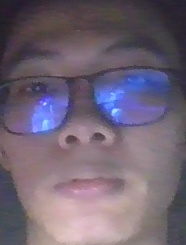

[[ 6.79184720e-02  2.41517112e-01  1.49636060e-01  7.32382759e-02
   2.20742952e-02  3.22697237e-02  1.46863565e-01 -8.29664469e-02
  -1.24588512e-01  8.63150805e-02  2.70206053e-02 -3.77506763e-02
   3.95964505e-03  3.65226679e-02  1.07158169e-01 -1.05333768e-01
   1.02400072e-01  8.33687484e-02  1.62013378e-02 -1.58160795e-02
  -2.98617641e-04  5.67370094e-03 -7.21333474e-02 -1.71034422e-03
   7.12655932e-02 -3.23484950e-02 -1.45506829e-01  6.06641695e-02
   1.25927404e-01  1.00742303e-01 -1.00332938e-01  1.08910970e-01
  -5.29881455e-02  5.37866764e-02  1.10883579e-01 -8.54586437e-02
   1.36649579e-01  1.08915471e-01  7.76792988e-02 -1.26268059e-01
   3.24246399e-02 -3.11436132e-02  7.42293298e-02 -8.96819010e-02
  -1.15941666e-01  1.38838455e-01  6.55718073e-02 -2.57734656e-02
  -1.54592887e-01 -7.32267201e-02  1.03548929e-01  1.97616175e-01
  -7.12787509e-02  4.16862555e-02  1.03971839e-01 -1.94127653e-02
  -1.81212220e-02 -4.24141586e-02 -3.95733975e-02 -5.23582511e-02
   1.75564

In [5]:
# Trích xuất đặc trưng cho một ảnh
quoc = path + '/FaceImage/FaceImage/1721031276_ThachAnhQuoc/image_1060.jpg'
img1 = cv2.imread(quoc)

# Copy cái ảnh
image = img1.copy()

# Lấy chiều cao và chiều rộng của ảnh
h, w = image.shape[:2]

# Chuẩn bị dữ liệu đầu vào cho mô hình nhận diện khuôn mặt
imgBlob = cv2.dnn.blobFromImage(image, 1, (300,300), (104, 177, 123), swapRB=False, crop=False)

# Thiết lập đầu vào cho mô hình
dectectorModel.setInput(imgBlob)

# Thực hiện việc nhận diện khuôn mặt
detections = dectectorModel.forward()

# Kiểm tra xem có khuôn mặt nào hay không?
if (len(detections)>0):
  # Chọn khuôn mặt có độ tin cậy cao nhất (confidence) cao nhất
  i = np.argmax(detections[0, 0, :, 2]) # Giá trị thứ 2 trong 7 giá trị cuối cùng => confidence
  confidence = detections[0, 0, i, 2]

  # Kiểm tra độ tin cậy có lớn hơn 0.5
  if (confidence>0.5):
      # Tính toán hộp bao quanh khuôn mặt
      box = detections[0, 0, i, 3:7]* np.array([w, h, w, h])
      (startX, startY, endX, endY) =box.astype('int')

      # Trích xuất vùng ảnh chứa khuôn mặt ra
      roi = image[startY:endY, startX:endX]
      cv2_imshow(roi)

      # Chuẩn bị dữ liệu đầu vào cho mô hình trích xuất đặc trưng
      faceBlob = cv2.dnn.blobFromImage(roi, 1/255, (96,96), (0,0,0), swapRB=True, crop=True)

      # Thiết lập đầu vào cho mô hình
      descriptorModel.setInput(faceBlob)

      # Thực hiện việc trích xuất đặc trưng
      vectors = descriptorModel.forward()

      # Print vectors
      print(vectors)

In [6]:
# Tạo ra một functions để áp dụng cho nhiều ảnh
def myDetect(image_path):
  # Trích xuất đặc trưng cho một ảnh
  img1 = cv2.imread(image_path)

  # Copy cái ảnh
  image = img1.copy()

  # Lấy chiều cao và chiều rộng của ảnh
  h, w = image.shape[:2]

  # Chuẩn bị dữ liệu đầu vào cho mô hình nhận diện khuôn mặt
  imgBlob = cv2.dnn.blobFromImage(image, 1, (300,300), (104, 177, 123), swapRB=False, crop=False)

  # Thiết lập đầu vào cho mô hình
  dectectorModel.setInput(imgBlob)

  # Thực hiện việc nhận diện khuôn mặt
  detections = dectectorModel.forward()

  # Kiểm tra xem có khuôn mặt nào hay không?
  if (len(detections)>0):
    # Chọn khuôn mặt có độ tin cậy cao nhất (confidence) cao nhất
    i = np.argmax(detections[0, 0, :, 2]) # Giá trị thứ 2 trong 7 giá trị cuối cùng => confidence
    confidence = detections[0, 0, i, 2]

    # Kiểm tra độ tin cậy có lớn hơn 0.5
    if (confidence>0.5):
        # Tính toán hộp bao quanh khuôn mặt
        box = detections[0, 0, i, 3:7]* np.array([w, h, w, h])
        (startX, startY, endX, endY) =box.astype('int')

        # Trích xuất vùng ảnh chứa khuôn mặt ra
        roi = image[startY:endY, startX:endX]
        # cv2_imshow(roi)

        # Chuẩn bị dữ liệu đầu vào cho mô hình trích xuất đặc trưng
        faceBlob = cv2.dnn.blobFromImage(roi, 1/255, (96,96), (0,0,0), swapRB=True, crop=True)

        # Thiết lập đầu vào cho mô hình
        descriptorModel.setInput(faceBlob)

        # Thực hiện việc trích xuất đặc trưng
        vectors = descriptorModel.forward()

        # Print vectors
        return vectors

In [7]:
# Apply for all images
# Khởi tạo một dictionary
data = dict(data=[], label=[])

myDir = '/content/drive/MyDrive/test_opencv/FaceImage/FaceImage'
folders = os.listdir(myDir)

# Duyệt qua từng thư mục
for folder in folders:
  path = myDir + "/"+folder
  print(path)

  files =  os.listdir(path)
  for fileName in files:
    try:
        # Gọi hàm trích xuất đặc trưng
        vector = myDetect(path+'/'+fileName)

        # Kiểm tra việc trích xuất đặc trưng thành công:
        if vector is not None:
          #Thêm vector đặc trưng vào trong từ điển với nhãn là tên của thư mục
          data['data'].append(vector)
          data['label'].append(folder)
          print('Trích xuất đặc trưng thành công')
    except:
      # Bỏ qua nếu gặp lỗi
      pass

/content/drive/MyDrive/test_opencv/FaceImage/FaceImage/1721031615_VuDinhNguyen
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thành công
Trích xuất đặc trưng thàn

In [8]:
# Tạo một series từ dictionary
labelSeries = pd.Series(data['label'])
# Đếm số lần xuất hiện của mỗi nhãn
labelCounts = labelSeries.value_counts()
print(labelCounts)

1721030566_LeNguyenHoang         150
1721030676_NguyenChauNhutPhi     137
1721030848_LeQuocKy              135
1721031129_TranAnhHao            130
172100257_LuongThanhPhong        121
                                ... 
1721030545_NguyenHoangTuanAnh     10
1721030497_HoThienSinh             9
172100103_tranquangthuan           8
1721021119_TranDuyHa               6
1721030802_NguyenNhatTien          5
Name: count, Length: 94, dtype: int64


In [9]:
# Save data -> file
print('/content/drive/MyDrive/test_opencv/')
fileName = '/content/drive/MyDrive/test_opencv/data_face_features.pickle'
pickle.dump(data, open(fileName, mode='wb'))

/content/drive/MyDrive/test_opencv/
